# Simulated Data for AD Treatment

## Imports

In [14]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.signal as sig
from scipy import fft
from scipy import stats

In [3]:
import sys  
sys.path.insert(0, 'C:/Users/mauma/OneDrive/Documents/UCLA/BioHackathon')

import stattest

## Simulated Behavior Metrics

In [ ]:
def shapiro_wilk_test(sample, x_lab, **kwargs):
    wstat, pval = stats.shapiro(sample)
    
    sns.set_theme(style='dark')
    ax = sns.histplot(sample, **kwargs)
    ax.set(xlabel=x_lab)
    
    return ax, (wstat, pval)

In [ ]:
def t_test(samples, test_type, sample_names, y_lab, **kwargs):
    samp1, samp2 = samples
    name1, name2 = sample_names
    
    samp1 = np.asarray(samp1)
    samp2 = np.asarray(samp2)
    
    n_1 = samp1.size
    n_2 = samp2.size
    
    vals = np.hstack((samp1, samp2))
    
    stat_sig = False
    
    d = {
        'vals': vals,
        'label': np.hstack((np.repeat(name1, n_1), np.repeat(name2, n_2)))
    }
    df = pd.DataFrame(data=d)
    
    if test_type == 'students':
        ttest = stats.ttest_ind(samp1, samp2)
    elif test_type == 'within-subjects':
        ttest = stats.ttest_rel(samp1, samp2)
    pval = ttest.pvalue
    
    if pval < 0.001:
        stars = "***"
        stat_sig = True
    elif pval < 0.01:
        stars = "**"
        stat_sig = True
    elif pval < 0.05:
        stars = "*"
        stat_sig = True
    
    sns.set_theme()
    ax = sns.boxplot(data=df, x='label', y='vals', **kwargs)#, hue='label')
    ax.set(xlabel='', ylabel=y_lab)
    
    if stat_sig:
        vspace = stats.tstd(vals) / 10
        y, h, col = np.max(vals) + vspace, vspace, '#3F3F3F'
    
        plt.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((0+1)*.5, y+(h*0.7), stars, ha='center', va='bottom', color=col)
        
    return ax, (vals, pval)

<Axes: >

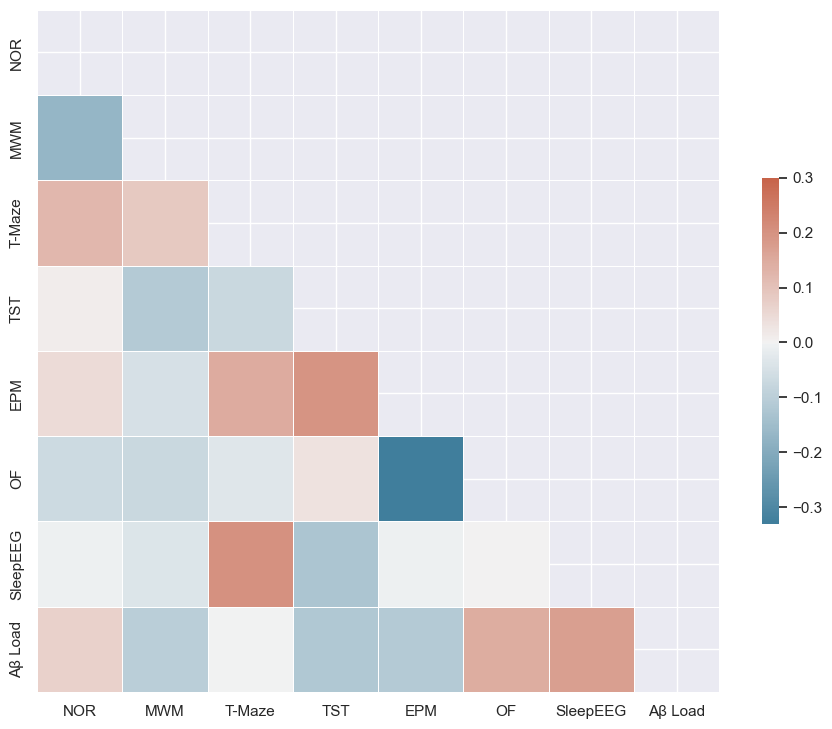

In [18]:
rs = np.random.RandomState(1)
d = pd.DataFrame(data=rs.normal(size=(100, 8)),
                 columns=["NOR", "MWM", "T-Maze", "TST", "EPM", "OF", "SleepEEG", "Aβ Load"])

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Simulating LFP and changes in $\gamma$-band power

In [ ]:
# TO-DO: calculate power of test to find good sample size

In [4]:
d17212 = np.fromfile("C:/Users/mauma/OneDrive/Documents/UCLA/BioHackathon/d17212.001.dat", dtype="byte")

In [5]:
d_nsamps = d17212.size
nsamps = int(d_nsamps / 8)

t = np.linspace(0, 750, nsamps)

fs = 20000

In [6]:
ch_indices = np.zeros((8, nsamps))
for i in range(8):
    ch_indices[i] = np.arange(i, d_nsamps+i, 8)
    
ch_indices = ch_indices.astype(int)

In [7]:
x=d17212[ch_indices[0]][t < 7]
#x = d17212[:446]

In [8]:
sos = sig.butter(2, [3*2/fs, 100*2/fs], btype='bandpass', output='sos') #create the bandpass filter
filt_data = sig.sosfilt(sos, x)

In [9]:
filt_data2 = sig.sosfilt(sos, d17212[ch_indices[2]][t < 7])

In [10]:
sim_filt_data = filt_data/2
sim_filt_data[100000:200000] = filt_data[100000:200000] * 1.5

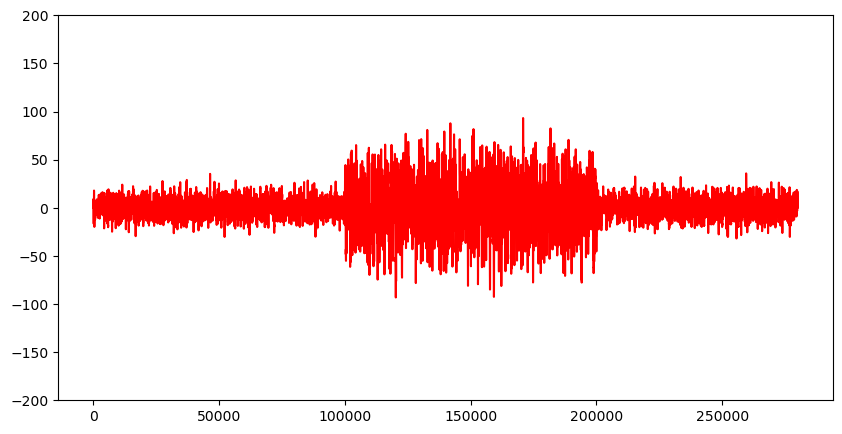

In [12]:
plt.figure(figsize=(10,5))
plt.ylim([-200, 200])
plt.plot(sim_filt_data, color='r')
#plt.axvspan(100000, 200000, facecolor='#00b7ff', alpha=0.3)
plt.show()

In [15]:
gamma_pwr_ON = np.random.normal(30, 4, 10)
gamma_pwr_OFF = np.random.normal(10, 4, 10)

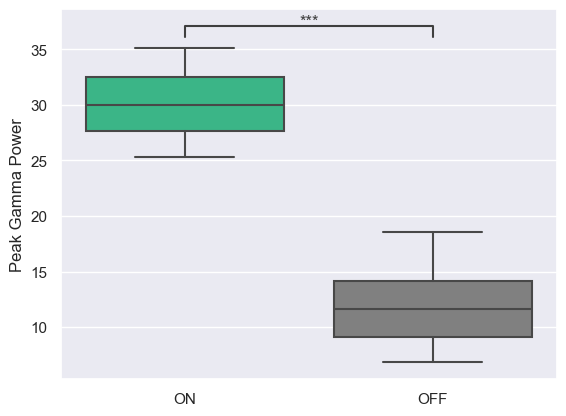

In [17]:
stim_colors = {'ON':'#26CA8C', 'OFF':'grey'}
ogs_exp = stattest.t_test((gamma_pwr_ON, gamma_pwr_OFF),
                          'within-subjects',
                          ("ON", "OFF"),
                          "Peak Gamma Power",
                          palette=stim_colors)

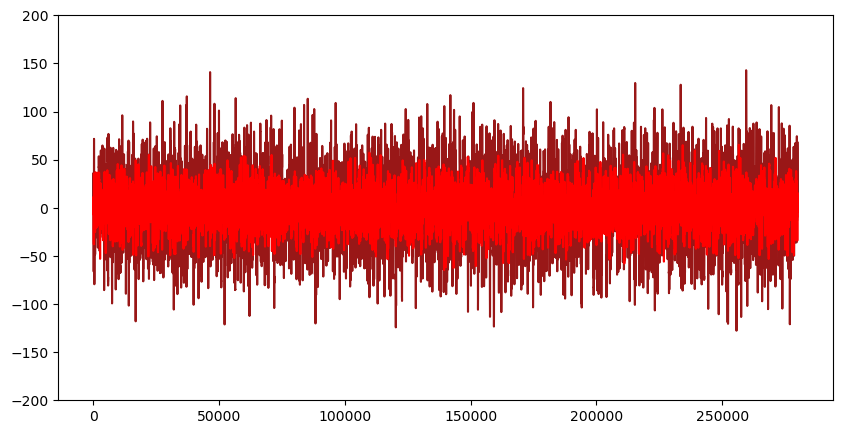

In [11]:
plt.figure(figsize=(10,5))
plt.ylim([-200, 200])
plt.plot(filt_data * 2, color='#991717')
plt.plot(filt_data2, color='red')
#plt.axvspan(100000, 200000, facecolor='#00b7ff', alpha=0.3)
plt.show()

In [27]:
cgs_treat = np.hstack([np.repeat("CGS", 10), np.repeat("Sham", 10), np.repeat("Control", 10)])
cgs_treat_labels = np.hstack((cgs_treat, cgs_treat, cgs_treat, cgs_treat))

In [28]:
cgs_days = np.repeat(np.arange(1, 5), 30)

In [29]:
pgp_vals = np.hstack((gamma_pwr_C1,
                      gamma_pwr_S1,
                      gamma_pwr_N1,
                      gamma_pwr_C2,
                      gamma_pwr_S2,
                      gamma_pwr_N2,
                      gamma_pwr_C3,
                      gamma_pwr_S3,
                      gamma_pwr_N3,
                      gamma_pwr_C4,
                      gamma_pwr_S4,
                      gamma_pwr_N4))

gamma_pwr_d = {
    'Peak gamma power': pgp_vals,
    'Treatment': cgs_treat_labels,
    'Day since AD model applied': cgs_days
}

gpdf = pd.DataFrame(gamma_pwr_d)

c_colors = {'CGS':'#24d34e', 'Sham':'grey', 'Control':'white'}

<Axes: xlabel='Day since AD model applied', ylabel='Peak gamma power'>

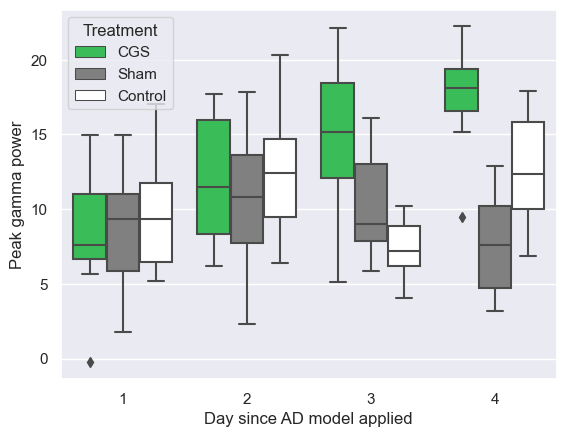

In [30]:
sns.set_theme()
sns.boxplot(data=gpdf, x='Day since AD model applied', y='Peak gamma power', hue='Treatment', palette=c_colors)

In [19]:
gamma_pwr_C1 = np.random.normal(9, 4, 10)
gamma_pwr_S1 = np.random.normal(10, 4, 10)
gamma_pwr_N1 = np.random.normal(10, 4, 10)

gamma_pwr_C2 = np.random.normal(11, 4, 10)
gamma_pwr_S2 = np.random.normal(10, 4, 10)
gamma_pwr_N2 = np.random.normal(11, 4, 10)

gamma_pwr_C3 = np.random.normal(15, 4, 10)
gamma_pwr_S3 = np.random.normal(10, 4, 10)
gamma_pwr_N3 = np.random.normal(9, 4, 10)

gamma_pwr_C4 = np.random.normal(19, 4, 10)
gamma_pwr_S4 = np.random.normal(10, 4, 10)
gamma_pwr_N4 = np.random.normal(10, 4, 10)

In [21]:
cbpm_treat = np.hstack([np.repeat("Control", 10),
                        np.repeat("LIFUP", 10),
                        np.repeat("TMS", 10),
                        np.repeat("OGS", 10),
                        np.repeat("CGS", 10)])

ad_applied = np.hstack((np.ones(25), np.zeros(25)))
random.shuffle(ad_applied)

In [22]:
ad_labels = []
for i in ad_applied:
    if i==1.:
        ad_labels.append("AD")
    else:
        ad_labels.append("Control")
ad_labels = np.asarray(ad_labels)

In [23]:
cbpm_scores = np.random.normal(30, 10, 50)

In [24]:
cbpm_d = {
    'γ-stimulation': cbpm_treat,
    'AD model': ad_labels,
    'CBPM':cbpm_scores
}
cbpm_df = pd.DataFrame(cbpm_d)

In [25]:
ad_pal = c_colors = {'AD':'darkred', 'Control':'white'}

<Axes: xlabel='γ-stimulation', ylabel='CBPM'>

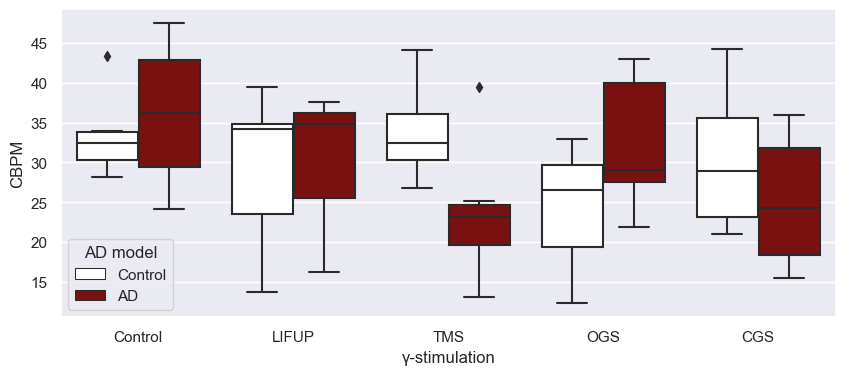

In [26]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=cbpm_df, x='γ-stimulation', y='CBPM', hue='AD model', palette=ad_pal)